In [1]:
%matplotlib inline

from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from sklearn import preprocessing

import zipcodes as zcs

data = pd.read_csv('data.csv')
columns = list(data.head())
data.head()


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


Next Step is to import the data, and clean it up. "clean up" in this case involves:
* removing entries where values are zero that shouldn't be (see `greater_than_zero` list).  
* Year Renovated is frequently zero. I take this to mean it has never been renovated, so it is then substituted with year built.
* all location data is substituted with the latitude and longitude provided by the zip code. The data is also removed.
* The value to be predicted is calculated as price/sqft_living
* A few outliers in price/sqft are removed. Some very small properties sold for millions. This greatly throws of my MSE. Removing this outliers just means that I won't be able to predict the multi-million dollar homes as well. This is acceptable because they make up so few of the dataset, and the 'average home buyer' probably won't be trying to buy such an expensive house
* All data is scaled with a robust scaler. Median = 0 and scaled by the IQR


In [2]:
##do some data clean up, remove ill-formed entries
greater_than_zero = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                     'floors', 'yr_built']
(n_rows,_) = data.shape
mask = np.zeros(n_rows ) > 0
print("number of rows: {:}".format(n_rows))
for col in greater_than_zero:
    cur_mask = data[col] <= 0
    mask = mask | cur_mask
    print("{:<10}\t{:} less than or equal to zero".format(col, np.sum(mask)))

data.drop( data[mask].index, axis=0, inplace=True)   
(n_rows,_) = data.shape
print("\tAfter removal")
print("\tnumber of rows: {:}".format(n_rows))

#if no date is listed for renovation, assume last 'renovation' was when it was built
temp = [reno if reno > 0 else built for reno,built in zip(data['yr_renovated'], data['yr_built'])]
data['yr_renovated'] = temp

#replace location data with latlong, remove other data
latlong = [ zcs.matching(z.split(' ')[1])[0] for z in data['statezip'] ]
data['lat'] = [ x['lat'] for x in latlong ]
data['long'] = [ x['long'] for x in latlong ]
data.drop(['statezip'], axis=1)
data['price/living'] = [p/r for p,r in zip(data['price'],data['sqft_living'])]

#drop column country because it's all USA, drop street because it's two unique. Very few repeats
data.drop(['country','street','city','statezip','date'],axis=1,  inplace=True)

#an outlier!
mask = data['price/living'] > 1000 
data[ mask ]
data.drop( data[mask].index, axis=0, inplace=True)   
d = data.values
scaler = preprocessing.RobustScaler()
data_scaled = scaler.fit_transform(d)
df_scaled = pd.DataFrame(data_scaled, columns=list(data))

x_str = list(data)
x_str.remove('price')
x_str.remove('price/living')
X = df_scaled[x_str]
Y = df_scaled['price/living']


number of rows: 4600
price     	49 less than or equal to zero
bedrooms  	51 less than or equal to zero
bathrooms 	51 less than or equal to zero
sqft_living	51 less than or equal to zero
sqft_lot  	51 less than or equal to zero
floors    	51 less than or equal to zero
yr_built  	51 less than or equal to zero
	After removal
	number of rows: 4549


In [3]:

print( df_scaled['price/living'].describe() )
df_scaled.head()

count    4544.000000
mean        0.123928
std         0.804877
min        -1.773849
25%        -0.472378
50%         0.000000
75%         0.527622
max         4.180806
Name: price/living, dtype: float64


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,price/living
0,-0.459735,0.0,-1.000000,-0.547826,0.038835,0.0,0.0,0.0,0.0,-0.225225,0.000000,-0.456522,0.352,0.833333,-0.545455,-0.088590
1,5.804159,2.0,0.333333,1.460870,0.229327,0.5,0.0,4.0,2.0,1.603604,0.466667,-1.195652,-2.336,0.277778,-0.681818,3.073924
2,-0.372023,0.0,-0.333333,-0.034783,0.714262,-0.5,0.0,0.0,1.0,0.306306,0.000000,-0.217391,-0.896,-1.222222,0.545455,-0.513557
3,-0.136106,0.0,0.000000,0.026087,0.058587,-0.5,0.0,0.0,1.0,-0.531532,1.666667,-0.282609,-0.992,0.111111,0.500000,-0.266341
4,0.257089,1.0,0.333333,-0.026087,0.472046,-0.5,0.0,0.0,1.0,-0.405405,1.333333,0.000000,-0.064,0.555556,0.454545,0.287707


In [4]:
def x_val(X, Y, model, fold_count=10, reps=3):
    (n_data, _) = X.shape
    ind = np.arange( n_data)%fold_count
    r2 = {}
    r2['train'] =[]
    r2['test'] = []
    
    result = {}
    
    for rep in np.arange(reps):
    
        np.random.shuffle(ind)
        x_test = X[ ind == 0 ]
        x_train = X[ ind != 0 ]
        y_test = Y[ind == 0]
        y_train = Y[ind != 0]
        
        n_test = np.sum( ind == 0)
        n_train = np.sum( ind != 0 )
        
        model.fit(x_train, y_train)
        yhat_train = model.predict(x_train)
        res_train = y_train/(n_train**(1/2)) - yhat_train/(n_train**(1/2))
        mse_train = np.sum( res_train**2 )
        r2_train = 1 - mse_train / np.var(y_train)
        
        yhat_test = model.predict(x_test)
        res_test = y_test/(n_test**(1/2)) - yhat_test/(n_test**(1/2))
        mse_test = np.sum( res_test**2 )
        r2_test = 1 - mse_test / np.var( y_test )
        #print("1-{:.3f}/{:.3f}={:.3f}".format(mse_test, np.var(y_test), r2_test) )

        
        
        r2['train'].append( r2_train/reps )
        r2['test'].append( r2_test/reps)
        
        
    result['train'] = np.sum( r2['train'] )
    result['test'] = np.sum( r2['test'])
    
    return result

def val_cur( X, Y, model, param, ks, fold_count = 10, reps=3):
    
    result = {'train': [],
             'test':[]}
    
    
    for k in ks:
        d = {param:k}
        model = model.set_params(**d)
        temp = x_val(X, Y, model )
        result['train'].append( temp['train'] )
        result['test'].append(temp['test'])
        
    
    return result
    

        
def boot(X, Y, F, n = 100):
    result = {'train': np.array([]) ,
             'test': np.array([]) }
    
    (n_data, _) = X.shape

    
    
    for ind in np.arange(n):
        boot_ind = np.random.choice( np.arange(n_data),
                                    n_data, replace=True)
        X_boot = X.loc[boot_ind]
        Y_boot = Y.loc[boot_ind]
        temp = F( X_boot, Y_boot )
        if result['train'].size == 0:
            result['train'] = np.array(temp['train'])
            result['test'] = np.array(temp['test'])
        
        else: 
            result['train'] = np.vstack( (result['train'] , 
                                          np.array(temp['train'] ) )  )
            result['test'] =  np.vstack( (result['test'] , 
                                          np.array(temp['test'] ) )  )
            
  
    return result

Just running an initial decision tree with a depth of 5 to see how this might work and which factors might be important.

MSE:	0.306
Var:	0.648
R^2:	0.5270407625468747


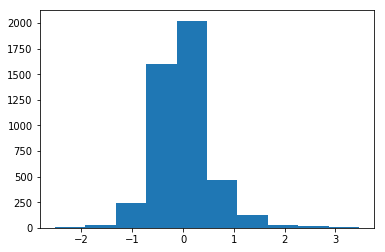

In [5]:
from sklearn.ensemble import RandomForestRegressor as RFR
np.random.seed(8675309)

clf = tree.DecisionTreeRegressor(max_depth=4)
clf = clf.fit(X,Y)
yhat_clf = clf.predict(X)
residual_clf = Y - yhat_clf

plt.figure()
plt.hist(  residual_clf )
mse = np.mean( residual_clf**2)
print("MSE:\t{:.3f}".format(mse))
print("Var:\t{:.3f}".format(np.var(Y)))
print("R^2:\t{:}".format(1 - mse/np.var(Y)) )


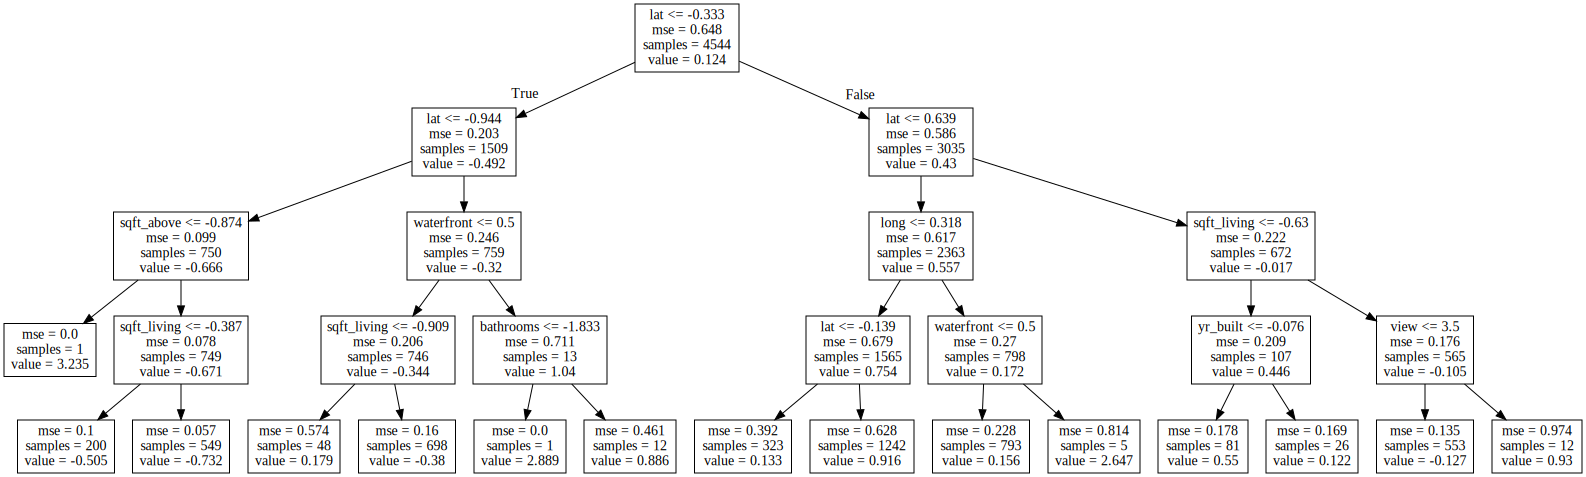

In [6]:
dot_data = tree.export_graphviz(clf, out_file=None,
                               feature_names=x_str)
graph = graphviz.Source(dot_data)
graph

An $R^2$ of ~0.5 (without cross validation) isn't a very promising start. However, it does give clues as to which will be important. It seems the realty mantra of "Location, Location, Location" seems to hold up, as LatLong seem to be the most import factors.  

Now lets try refining a decision forest. I'll start with a validation curve to check how 'deep' each tree should be. I'll be using the default forest size of 10.

In [7]:

np.random.seed(867539)
rfr = RFR(n_estimators=10)

ks = np.arange(1,25)
r2 = val_cur( X, Y, rfr, 'max_depth', ks, reps=3)
tree_lam = lambda a,b :val_cur( a, b, rfr, 'max_depth', ks)
r2 = boot( X, Y, tree_lam, n = 10)

[0.8233167]


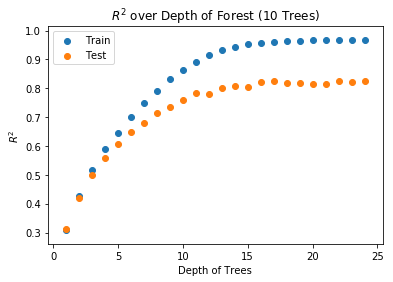

In [8]:
plt.figure()
plt.scatter(ks, np.mean(r2['train'], axis = 0), label='Train' )
plt.scatter(ks, np.mean(r2['test'], axis = 0), label='Test')
plt.legend()
plt.title('$R^2$ over Depth of Forest (10 Trees)')
plt.xlabel('Depth of Trees')
plt.ylabel('$R^2$')
print( np.mean(r2['test'], axis=0)[np.where(ks==16)] )


It looks like the increase in $R^2$ seems to be diminished after about a depth of 16. However, an $R^2$ of over 0.8 is much better!  

Now lets see how many trees we need in our forest to get a good result using a depth of 16.

In [9]:

np.random.seed(867539)
rfr = RFR(max_depth=16)

ks = np.arange(5,20)
#r2 = val_cur( X, Y, rfr, 'n_estimators', ks, reps=3)
tree_lam = lambda a,b :val_cur( a, b, rfr, 'n_estimators', ks)
r2 = boot( X, Y, tree_lam, n = 10)

[0.83724165]


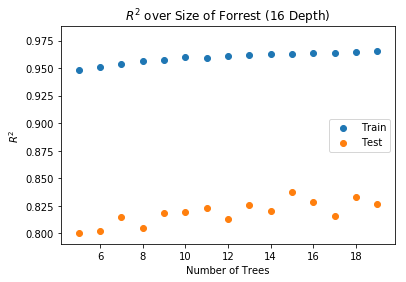

In [10]:
plt.figure()
plt.scatter(ks, np.mean(r2['train'], axis = 0), label='Train' )
plt.scatter(ks, np.mean(r2['test'], axis = 0), label='Test')
plt.legend()
plt.title('$R^2$ over Size of Forrest (16 Depth)')
plt.xlabel('Number of Trees')
plt.ylabel('$R^2$')
print( np.mean(r2['test'],axis=0)[np.where(ks==15)] )


In [11]:

np.random.seed(867539)
rfr = RFR(max_depth=16)

ks = np.arange(10,101,10)
tree_lam = lambda a,b :val_cur( a, b, rfr, 'n_estimators', ks)
r2 = boot( X, Y, tree_lam, n = 10)

[0.82939988]


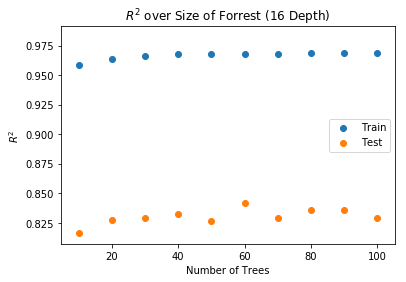

In [12]:
plt.figure()
plt.scatter(ks, np.mean(r2['train'], axis = 0), label='Train' )
plt.scatter(ks, np.mean(r2['test'], axis = 0), label='Test')
plt.legend()
plt.title('$R^2$ over Size of Forrest (16 Depth)')
plt.xlabel('Number of Trees')
plt.ylabel('$R^2$')
print( np.mean(r2['test'],axis=0)[np.where(ks==100)] )

There does a positive correlation between number of trees that doesn't level off within the range that I have shown. Lets try a few more...

In [13]:
np.random.seed(8675309)
rfr = RFR(n_estimators=100, max_depth=16)
rfr = rfr.fit(X,Y)
feat_imp = rfr.feature_importances_
indices = np.argsort(feat_imp)[::-1]
print("Feature\t\tImportance")
print("--------------------------")
for ind in indices:
    print( "{:}\t{:0.3f}".format(list(X)[ind].ljust(9), feat_imp[ind]))

Feature		Importance
--------------------------
lat      	0.458
sqft_living	0.109
long     	0.103
sqft_lot 	0.057
yr_built 	0.051
sqft_basement	0.040
sqft_above	0.040
yr_renovated	0.033
view     	0.030
waterfront	0.024
bathrooms	0.021
bedrooms 	0.014
condition	0.014
floors   	0.007


Based on the above results, with a depth of 16 and forest of 100 trees, the three most import features are Latitude, living space, and Longitude. Although it doesn't seem like there is much benefit to adding more trees as the $R^2$ seems to have leveled out around 0.82.